In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pathlib

sys.path.append(str(pathlib.Path().cwd().parent))

In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

from load_dataset import Dataset
from plotting import plot_ts

### Пример. Использование полносвязной сети в классической постановке задачи прогнозирования одномерного ряда (n лагов в качестве признаков, 1 лаг в качестве ответа).

#### Возьмем уже известный ряд international-airline-passengers.csv

In [4]:
dataset = Dataset('../data/dataset/')

In [5]:
ts = dataset['international-airline-passengers.csv']

In [6]:
ts.head()

1949-01
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
Name: 112, dtype: int64

<AxesSubplot:xlabel='1949-01'>

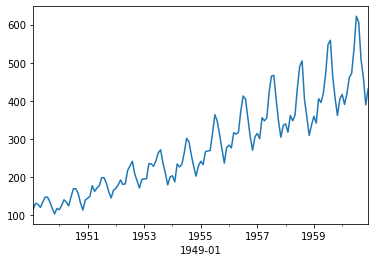

In [7]:
ts.plot()

#### Зададим количество лагов и разобъем на train и test.

In [8]:
num_lags = 12

In [9]:
ts_train, ts_test = ts[:100], ts[100 - num_lags:]

#### Возьмем нашу функцию для перехода к supervised задаче с одной точкой в качестве ответа

In [11]:
from typing import Tuple
def transform_into_matrix(ts: pd.Series, num_lags: int) -> Tuple[np.array]:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [ ]:
X_train, y_train = transform_into_matrix(ts_train, num_lags)

In [ ]:
X_test, y_test = transform_into_matrix(ts_test, num_lags)

#### Зададим однослойную сеть с 64 нейронами на входном слое, и размерностью, равной количество лагов.

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=num_lags))

#### Зададим выходной слой с одним нейроном

In [ ]:
model.add(Dense(1))

#### Скомпилируем и обучим сетку.

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X_train, y_train, epochs=2000, verbose=0)

#### Получим one-step-ahead прогноз на тест

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
plot_ts(ts_train, ts_test, pd.Series(y_pred.squeeze(), index=ts_test.index[num_lags:]))

#### Мы видим достаточно неплохое качество прогноза, однако каких-то качественных улучшений по сравнению с линейной регрессией, запущенной из коробки мы не видим.

In [ ]:
from model import TimeSeriesPredictor

predictor = TimeSeriesPredictor(granularity='P1M', num_lags=12)

In [ ]:
predictor.fit(ts_train)

In [ ]:
preds = predictor.predict_batch(ts_train, ts_test)

In [ ]:
plot_ts(ts, preds)

#### Тем не менее, в плане out-of-sample прогноза, запущенная из коробки lr показывает беду

In [ ]:
preds_out_of_sample = predictor.predict_next(ts_train, len(ts_test))

In [ ]:
plot_ts(ts, preds_out_of_sample)

## Решение - попробуем сформировать датасет так, чтобы учиться предсказать сразу 12 точек! Для этого как раз удобно использовать полносвязную сеть.

### Задание 1. Использование полносвязной сети для предсказания следующих 12 точек

### Задача - по предыдущем n точкам научиться предсказывать следующие m точек

In [ ]:
ts = dataset['alcohol_sales.csv']

### 1) Реализовать функцию разбиения одномерного ряда на входные данные для сетки

* принимает на вход ряд, количество входных и выходных лагов
* функция должна пройтись скользящим оконом ширины num_lags_in по временному ряду и для каждой итерации получить в качестве ответов следующие num_lags_out количество лагов
* каждый раз окно сдвигается на 1 лаг
* возращает два np.array X, y

In [ ]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    # your code here
    return np.array(X), np.array(y)

#### 2) Разбить на трейн и тест, отложив в качестве теста последние 12 точек (обратите внимание, что в таком случае в  качестве X_test и y_test у вас будет всего один объект)

In [ ]:
# ваш код здесь
num_lags = 24
num_output = 12
X, y = transform_ts_into_matrix(ts, num_lags, num_output)

In [ ]:
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[[-1]], y[-1]

#### 3) Построить полносвязную сеть, указав нужное количество входных и выходных слоев

* в качестве архитектуры возьмите популярную конфигурацию слоев с 64 и 32 нейронами
* на первом слое необходимо указать входную размерность, равную количеству лагов на входе
* на выходном слое необхдимо указать количество нейронов, равное количеству выходных лагов
* activation, optimizer, loss можете выбрать сами, по умолчанию 'relu', 'adam', 'mse'

In [ ]:
# ваш код здесь

#### 4) Обучить сеть.

In [ ]:
#ваш код здесь

#### 5) Сделайте предикт на тесте и сравните результат с предыдущим подходом

In [ ]:
# ваш код здесь

### Использование полносвязной сети для предсказания многомерного ряда

In [ ]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [ ]:
ts.head()

In [ ]:
ts.plot(figsize=(20, 10))

In [ ]:
ts.fillna(ts.median(), inplace=True)

#### 1) Реализовать функцию, которая разбивает исходный ряд на входные данные X и y для сетки

In [ ]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    # your code here
    return np.array(X), np.array(y)

In [ ]:
n_lags = 24

In [ ]:
X, y = transform_multi_ts_into_matrix(ts, n_lags)

In [ ]:
X.shape

#### 2) Разбить на трейн и тест

In [ ]:
# ваш код здесь

#### 3) Построить полносвязную сеть, указав нужное количество входных и выходных слоев

In [ ]:
# ваш код здесь
n_dims = 9

####  4) Обучить модель 

In [ ]:
# ваш код здесь

#### 5) Сделайте прогноз

In [ ]:
# ваш код здесь